In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import random
from IPython import display
from sklearn import datasets, preprocessing

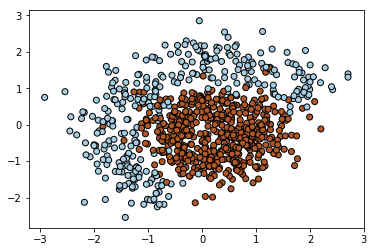

In [2]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = (y==1) | (X[:,1] > X[:,0] - 0.5)

X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
plt.show()

X, y = torch.FloatTensor(X), torch.FloatTensor(y)

In [3]:
import numpy as np

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, loss, n_iter):    
    plt.clf()
    xy = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    Z = classify(xy, w)
    
    Z = Z.numpy()
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [4]:
def expand(X):
    prod = X[:,0] * X[:,1]
    prod = prod.unsqueeze(1)
    oness = torch.ones_like(X[:, 0])
    oness = oness.unsqueeze(1)
    res = torch.cat([X, X ** 2, prod, oness], dim=1)
    return torch.FloatTensor(res)

def classify(X, w):
    return expand(X).mv(w).sign()

In [5]:
def get_delta(x, y, w):
    return 1 - y * x.mv(w)

def compute_loss(X, y, w):
    xx = expand(X)
    delta = get_delta(xx, y, w)
    return delta.max(torch.zeros_like(delta)).mean()

def compute_grad(X, y, w):
    xx = expand(X)
    xt = xx.t()
    delta = get_delta(xx, y, w)
    return torch.where(delta > 0, -xt * y, torch.zeros_like(xt)).mean(dim=1)

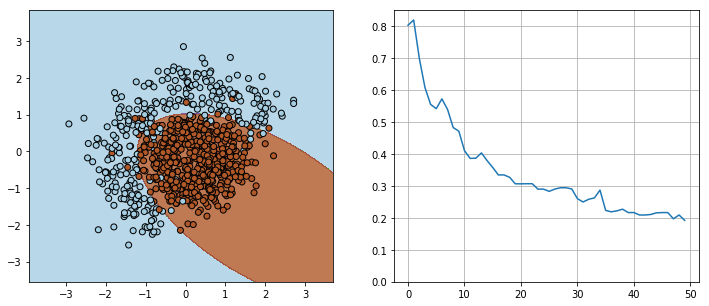

<Figure size 864x360 with 0 Axes>

In [26]:
# Training

w = torch.Tensor([1, 0, 0, 0, 0, 0])

alpha = 0.2

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)
    
    w -= alpha * compute_grad(X[ind,:], y[ind], w)

print(w.shape)
visualize(X, y, w, loss, n_iter)
plt.clf()

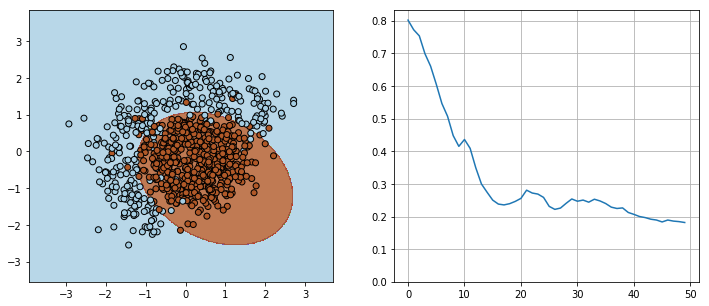

<Figure size 864x360 with 0 Axes>

In [27]:
# Gradient with momentum

w = torch.Tensor([1, 0, 0, 0, 0, 0])

alpha =  0.1
mu    =  0.6

v = torch.zeros_like(w)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)
    
    v = mu * v - alpha * compute_grad(X[ind,:], y[ind], w)
    w += v

visualize(X, y, w, loss, n_iter)
plt.clf()

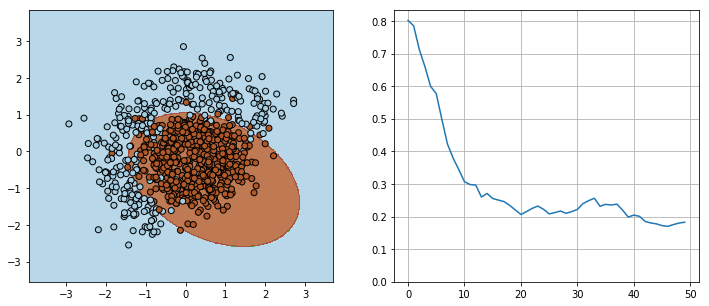

<Figure size 864x360 with 0 Axes>

In [28]:
# Nesterov

w = torch.Tensor([1, 0, 0, 0, 0, 0])

alpha = 0.2
mu    = 0.5

v = torch.zeros_like(w)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)
    
    v = mu * v - alpha * compute_grad(X[ind,:], y[ind], w + mu * v)
    w += v

visualize(X, y, w, loss, n_iter)
plt.clf()

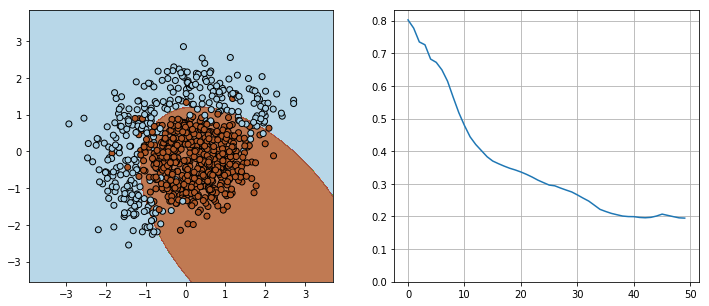

<Figure size 864x360 with 0 Axes>

In [32]:
# Adam

w = torch.Tensor([1, 0, 0, 0, 0, 0])

alpha = 0.1
beta = 0.9
mu = 0.7
eps = 1e-10

v = torch.zeros_like(w)
c = torch.zeros_like(w)


n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)
    
    grad = compute_grad(X[ind,:], y[ind], w)
    v = beta * v + (1 - beta) * grad
    c = mu * c + (1 - mu) * grad ** 2
    w -= alpha / ((c / (1 - mu ** (i + 1))).sqrt() + eps) * (v / (1 - beta ** (i + 1)))

visualize(X, y, w, loss, n_iter)
plt.clf()